#### References:
- tf.data.Dataset
  - https://www.tensorflow.org/guide/data?hl=en
  - https://www.tensorflow.org/guide/data_performance?hl=en
- Tensorflow + Audio
  - https://www.kaggle.com/enukuro/108th-place-solution-birdcall-keras-tpu
  - https://www.kaggle.com/tomdenton/birdclef2021-tfaudiodataset
  - https://www.tensorflow.org/io/tutorials/audio?hl=en

## Imports

In [1]:
import os
import tensorflow as tf
import tensorflow_io as tfio   #!pip install --user tensorflow-io
from matplotlib import pyplot as plt

print(tf.__version__)

2.6.0


## Constants

In [2]:
SEED        = 777
SAMPLE_RATE = 32000
SECONDS     = 5
BATCH_SIZE  = 3

## Set seed

In [3]:
os.environ['PYTHONHASHSEED'] = str(SEED)
#np.random.seed(SEED)
tf.random.set_seed(SEED)

## Dataset tranformation functions

In [4]:
def filepath_to_audio(file_path):
    
    # 1) Read X (audio wave) from file_path
    x_audio = tf.io.read_file(file_path)
    
    # The -32768 to 32767 signed 16-bit values will be scaled to -1.0 to 1.0 in float.
    x_audio, sample_rate = tf.audio.decode_wav(x_audio, 1)
    
    # 2) Read Y (label class) from file_path
    y = tf.strings.split(file_path, sep=os.path.sep)[-1]  #file_path.split("/")[1]
    
    return x_audio, y


def limit_seconds_audio(x_audio, y):
    
    len_audio = len(x_audio)
    effective_length = SAMPLE_RATE * SECONDS
    
    # Sorter audio --> Pad the end with zeros
    if len_audio <= effective_length:
        x_audio = tf.concat([x_audio, tf.expand_dims(tf.zeros([effective_length - len_audio]), 1)], axis=0)
        
    # Longer audio --> Random crop
    else:
        start = tf.random.uniform([1], maxval = len_audio - effective_length, dtype = tf.int32)[0]
        x_audio = x_audio[start : start+effective_length]
    
    return x_audio, y


def audio_to_mel_spectrogram(x_audio, y):
    x_audio = tf.squeeze(x_audio, axis=-1)
    
    # 1) Compute spectogram
    x_spectrogram = tfio.audio.spectrogram(x_audio, nfft=2048, window=2048, stride=320)

    # 2) Apply Mel scale to the spectogram
    x_mel_spectrogram = tfio.audio.melscale(x_spectrogram, rate=SAMPLE_RATE, mels=500, fmin=50, fmax=14000)
    
    # 3) Apply decibel scale
    x_dbscale_mel_spectrogram = tfio.audio.dbscale(x_mel_spectrogram, top_db=80)

    return x_dbscale_mel_spectrogram, y


def spectrogram_data_augmentation(spectrogram, y):
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    if  tf.random.uniform([]) > 0.7:
        spectrogram = augment_freq_time_mask(spectrogram)
    rand = tf.random.uniform([])
    if  rand < 0.3:
        spectrogram = augment_dropout(spectrogram, keep_prob=1-rand)
    if  tf.random.uniform([]) < 0.2:
        spectrogram = augment_pitch_and_tempo(spectrogram)
    spectrogram = tf.squeeze(spectrogram, axis=0)
    return spectrogram,y


def freq_mask(x_spectrogram, y):
    x_spectrogram = tfio.audio.freq_mask(x_spectrogram, param=10)
    return x_spectrogram,y

def standarize(x,y):
    x = x - tf.math.reduce_mean(x)
    x = x / tf.math.reduce_std(x)
    return x,y

def to3channels(x, y):
    x = tf.stack([x, x, x], axis=-1)
    return x,y

# Dataset

### Train dataset pipeline
1. Read audio wave from filepath
2. Remove silence from the begining and the end ([`tfio.audio.trim`](https://www.tensorflow.org/io/api_docs/python/tfio/audio/trim)) (OPTIONAL)
3. Limit audio to a fixed number of seconds
   - Sorter audio --> Pad the end with zeros
   - Longer audio --> Random crop
4. Data augmentation over audio wave
   - Change Speed
   - etc
5. Convert audio to MelSpectogram
   - 5.1. Convert audio to spectogram (`tfio.audio.spectrogram`)
   - 5.2. Apply the Mel scale (`tfio.audio.melscale`)
   - 5.3. Apply the DB scale (`tfio.audio.dbscale`)
6. Data augmentation over MelSpectogram
   - Time Masking (`tfio.audio.time_mask`)
   - Frequency Masking (`tfio.audio.freq_mask`)
   - Mixup
   - Any other image transformation
7. Add the coordconv channel (OPTIONAL)
8. Normalize (standard scale)
   - Apply the correct mean and std if transfer learning


In [6]:
AUTO = tf.data.AUTOTUNE

train_ds = (
           tf.data.Dataset.list_files("./sonidos/train/*/*.wav", shuffle=True)
           .map(filepath_to_audio,        num_parallel_calls=AUTO)
           .cache() # dataset until here will be cached in memory (for the 2nd epoch)
           .map(limit_seconds_audio,      num_parallel_calls=AUTO)
            # Data augmentation over audio wave here
            # End Data augmentation over audio wave
           .map(audio_to_mel_spectrogram, num_parallel_calls=AUTO)
            # Data augmentation over spectrogram here
           .map(freq_mask,                num_parallel_calls=AUTO)
            # End Data augmentation over spectrogram
           .map(standarize,               num_parallel_calls=AUTO)
           .shuffle(buffer_size=1024)
           #.repeat(count=-1) # Repeat indefinitely for an EarlyStopping training style
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(AUTO) # Optimization
)

valid_ds = (
           tf.data.Dataset.list_files("./sonidos/valid/*/*.wav", shuffle=False)\
           .map(filepath_to_audio,        num_parallel_calls=AUTO)
           .map(audio_to_mel_spectrogram, num_parallel_calls=AUTO)\
           .batch(BATCH_SIZE, drop_remainder=True)
           .prefetch(AUTO) # Optimization
)

In [7]:
it = iter(train_ds)
batch = it.next()
batch

2021-10-28 01:59:39.972965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(<tf.Tensor: shape=(3, 500, 500), dtype=float32, numpy=
 array([[[-0.5106511 ,  1.0732539 ,  1.7835428 , ...,  1.9903224 ,
           2.1145165 ,  1.9541597 ],
         [-0.5106511 ,  0.929192  ,  1.6394807 , ...,  1.9576335 ,
           2.133569  ,  1.9393082 ],
         [-0.5106511 ,  0.7342996 ,  1.444588  , ...,  1.9292173 ,
           2.0188296 ,  1.9741822 ],
         ...,
         [-0.5106511 , -0.5106511 , -0.5106511 , ..., -0.5106511 ,
          -0.5106511 , -0.5106511 ],
         [-0.5106511 , -0.5106511 , -0.5106511 , ..., -0.5106511 ,
          -0.5106511 , -0.5106511 ],
         [-0.5106511 , -0.5106511 , -0.5106511 , ..., -0.5106511 ,
          -0.5106511 , -0.5106511 ]],
 
        [[-1.2077194 ,  0.38383186,  0.89955676, ...,  1.7030301 ,
           1.6832517 ,  1.6847312 ],
         [-1.2077194 ,  0.38666388,  0.9023888 , ...,  1.7650297 ,
           1.6797761 ,  1.6426324 ],
         [-1.2077194 ,  0.29381442,  0.8095394 , ...,  1.7550893 ,
           1.6391945 ,  1.65

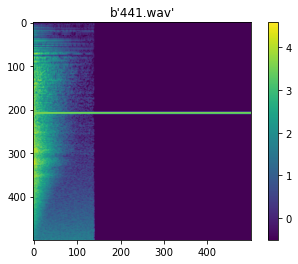

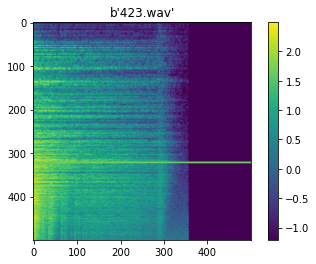

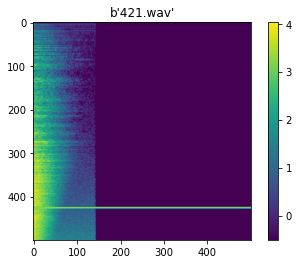

In [8]:
def show_batch(batch):
    specs  = batch[0]
    labels = batch[1]
        
    for i in range(len(specs)):
        plt.imshow(specs[i].numpy().T) # cmap='Greys', aspect='auto'
        plt.colorbar()
        plt.title(labels[i].numpy())
        plt.show()

show_batch(batch)

In [9]:
for x,y in train_ds:
    print(x.shape, y.shape)

(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)
(3, 500, 500) (3,)


## Model

In [ ]:
model.summary()

## Training

In [ ]:
optimizer= tfa.optimizers.RectifiedAdam(
    lr=1e-3,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-8,
)

model.compile(optimizer,
              loss="binary_crossentropy",
              loss_weights=,
              metrics=["accuracy",
                       F1,
                       true_positives,
                       possible_positives,
                       predicted_positives])


history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    callbacks=[reduce_lr, es, sv, f1cb],
)